<a href="https://colab.research.google.com/github/Esargenti/Analisis-Predictivo/blob/main/Examen2-Sargenti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Installs**

In [ ]:
! pip install skimpy
! pip install catboost

## **Imports**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from skimpy import skim
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from datetime import datetime
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV,\
RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
import catboost as cb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.svm import SVC
import lightgbm as lgb 

## **Carga de Datos**

In [3]:
import json
from google.colab import drive

!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
drive.mount("/content/drive", force_remount=True)


with open("/content/drive/MyDrive/1C-2023/Análisis Predictivo/Examen2/kaggle.json","r") as f:
  api_token=json.load(f)

with open("/root/.kaggle/kaggle.json", "w") as file:
  json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c analisis-predictivo-2023q1

import zipfile
import os

os.listdir()
for file in os.listdir():
  if file.endswith(".zip"):
    zip_ref=zipfile.ZipFile(file, "r")
    zip_ref.extractall()
    zip_ref.close()

Mounted at /content/drive
  0% 0.00/3.83M [00:00<?, ?B/s]
100% 3.83M/3.83M [00:00<00:00, 209MB/s]


In [4]:
#cargo los datos desde el archivo .csv
df=pd.read_csv("base_train.csv")

## **Vista de los Datos**

In [ ]:
df.columns

In [ ]:
df.info()

In [ ]:
pd.options.display.max_columns = None

In [ ]:
df.head(5)

In [ ]:
skim(df)

## **Distribución de la variable Target**

In [ ]:
df['review_scores_rating'].mean()

4.8123295454545465

In [ ]:
df['review_scores_rating'].median()

4.88

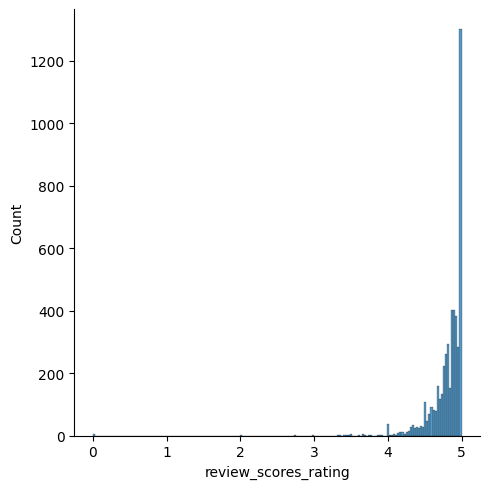

In [ ]:
sns.displot(df, x="review_scores_rating")

## **Correlaciones**

In [ ]:
df.corr()
sns.heatmap(df.corr())

## **Datos Duplicados**

In [ ]:
df.duplicated().sum()

# **Variables Numericas**

In [ ]:
df.describe().T

### Id, Neighbourhood group , Calendar

In [6]:
df=df.drop(["id","neighbourhood_group_cleansed", "calendar_updated"], axis=1)

In [7]:
mean_imputer = SimpleImputer(strategy='mean')

### **Convierto a 0 o 1 las variables T o F**

*Instant_bookable*

In [8]:
df.loc[df["instant_bookable"]=="f", "instant_bookable"] = 0
df.loc[df["instant_bookable"]=="t", "instant_bookable"] = 1
df.instant_bookable=df.instant_bookable.astype("int64")

*Host_has_profile_pic*

In [9]:
df.loc[df["host_has_profile_pic"]=="f", "host_has_profile_pic"] = 0
df.loc[df["host_has_profile_pic"]=="t", "host_has_profile_pic"] = 1
df.host_has_profile_pic=df.host_has_profile_pic.astype("int64")

*Host_identify_verified*

In [10]:
df.loc[df["host_identity_verified"]=="f", "host_identity_verified"] = 0
df.loc[df["host_identity_verified"]=="t", "host_identity_verified"] = 1
df.host_identity_verified=df.host_identity_verified.astype("int64")

*Host_is_superhost*

In [11]:
df.loc[df["host_is_superhost"]=="f", "host_is_superhost"] = 0
df.loc[df["host_is_superhost"]=="t", "host_is_superhost"] = 1
df["host_is_superhost"]=mean_imputer.fit_transform(df['host_is_superhost'].values.reshape(-1,1))
df.host_is_superhost=df.host_is_superhost.astype("int64")

*Has_availability*

In [12]:
df.loc[df["has_availability"]=="f", "has_availability"] = 0
df.loc[df["has_availability"]=="t", "has_availability"] = 1
df.has_availability=df.has_availability.astype("int64")

## **Variable Price**

In [13]:
# Remuevo $ y , de la variable
df.price = df.price.str.replace('$', '')
df.price = df.price.str.replace(',', '')
df.price = df.price.astype(float)

# convierto a int
df.price = pd.to_numeric(df.price, errors='coerce')

<ipython-input-13-4048ca88eccf>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.price = df.price.str.replace('$', '')


## **Response rate y Acceptance Rate**

*Host_Response_Rate*

In [14]:
df.host_response_rate = df.host_response_rate.str.replace('%', '')
df["host_response_rate"]=mean_imputer.fit_transform(df['host_response_rate'].values.reshape(-1,1))
df.host_response_rate=df.host_response_rate.astype("int64")

*Host_Acceptance_rate*

In [15]:
df.host_acceptance_rate = df.host_acceptance_rate.str.replace('%', '')
df["host_acceptance_rate"]=mean_imputer.fit_transform(df['host_acceptance_rate'].values.reshape(-1,1))
df.host_acceptance_rate=df.host_acceptance_rate.astype("int64")

## **Bathroom**

In [16]:
# Creo una nueva columna
df['bathrooms_numeric'] = df['bathrooms_text'].str.extract('(\d+\.\d+)', expand=False)
#Completo la columna bathrooms con la nueva info
df["bathrooms"]=df['bathrooms_numeric']
# Elimino la nueva columna
df=df.drop(["bathrooms_numeric"], axis=1)

In [17]:
# Si es Na extraigo solo el numero que tiene
df.loc[df["bathrooms"].isnull()==True, "bathrooms"] =df['bathrooms_text'].str.extract('(\d)', expand=False)

In [18]:
df.bathrooms = df.bathrooms.astype(float)

# **Variables Categoricas**

In [19]:
df=df.drop(["name","description", "neighborhood_overview","host_name", "host_about", "host_neighbourhood", "neighbourhood","bathrooms_text", "license" ], axis=1)
#Elimino neighbourhood porque la informacion necesaria está en neighbourhood_cleansed	

*Dummie-Source*

In [20]:
#Con la variable dummie se crean dos columnas para city_scrape o previous_scrape
source_nueva=pd.get_dummies(df["source"],prefix="source")
#Dejo solo la de city scrape
source_nueva=source_nueva.drop(["source_previous scrape"],axis=1)
#Elimino la columna de source
df=df.drop(["source"],axis=1)
#Reemplazo por la nueva 
df["Source"]=source_nueva

*Response Time*

In [21]:
def host_response_time(df):
  df["host_response_time"]=np.where(
      df["host_response_time"]==("within an hour"),1,np.where(
          df["host_response_time"]==("within a few hours"),2,np.where(
               df["host_response_time"]==("within within a day"),3,4
          )
      )
  )
  return df

In [ ]:
host_response_time(df)

Me quedo con el top 5 de las variables *host_location*, *neighbourhood_cleansed*, *property_type*. Luego las transformo en numericas

In [23]:
#Funcion para usar en ambas variables
def func(a, b):
    return not set(a).isdisjoint(b)

*host_location*

In [24]:
p_location=new = df["host_location"].str.split(",", expand = True)
df["host_location"]=p_location[1]
df["host_location"]=df["host_location"].str.lstrip()

In [25]:
df.loc[df["host_location"]=="CA", "host_location"] = "USA"
df.loc[df["host_location"]=="CO", "host_location"] = "USA"
df.loc[df["host_location"]=="DC", "host_location"] = "USA"
df.loc[df["host_location"]=="FL", "host_location"] = "USA"
df.loc[df["host_location"]=="IL", "host_location"] = "USA"
df.loc[df["host_location"]=="NY", "host_location"] = "USA"
df.loc[df["host_location"]=="RI", "host_location"] = "USA"

In [26]:
df.loc[df["host_location"].isnull()==True, "host_location"] = "missing"

In [27]:
location=pd.DataFrame(df["host_location"].value_counts().rename_axis('unique_values').reset_index(name='counts'))
res=location.groupby(['unique_values']).sum().reset_index()
top_5_location = res.sort_values('counts',ascending=False)['unique_values'].head(5)

In [28]:
dl=[]
for i in df['host_location']:
  x = i.split(",")
  respuesta_l=func(x,top_5_location)
  dl.append(respuesta_l)
df=df.drop(["host_location"],axis=1)
df['host_location'] = dl

In [29]:
df['host_location'] = df['host_location'].astype("int64")

*neighbourhood_cleansed*

In [30]:
p_neighbourhood=new = df["neighbourhood_cleansed"].str.split("-", expand = True)
neighbourhood=pd.DataFrame(p_neighbourhood[0].value_counts().rename_axis('unique_values').reset_index(name='counts'))
resultado=neighbourhood.groupby(['unique_values']).sum().reset_index()
top_5_neighbourhood = resultado.sort_values('counts',ascending=False)['unique_values'].head(5)

In [31]:
dn=[]
for i in df['neighbourhood_cleansed']:
  x = i.split("-")
  respuesta_n=func(x,top_5_neighbourhood)
  dn.append(respuesta_n)
df=df.drop(["neighbourhood_cleansed"],axis=1)
df['neighbourhood_cleansed'] = dn

In [32]:
df['neighbourhood_cleansed'] = df['neighbourhood_cleansed'].astype("int64")

*property_type*

In [33]:
property_t=pd.DataFrame(df["property_type"].value_counts().rename_axis('unique_values').reset_index(name='counts'))
resultado_p=property_t.groupby(['unique_values']).sum().reset_index()
top_5_property = resultado_p.sort_values('counts',ascending=False)['unique_values'].head(5)

In [34]:
dp=[]
for i in df['property_type']:
  x = i.split("-")
  respuesta_p=func(x,top_5_property)
  dp.append(respuesta_p)
df=df.drop(["property_type"],axis=1)
df['property_type'] = dp

In [35]:
df['property_type'] = df['property_type'].astype("int64")

*Amenities*

In [36]:
df.amenities = df.amenities.str.replace('[', '')
df.amenities = df.amenities.str.replace(']', '')
df.amenities = df.amenities.str.replace('"', '')
df.amenities = df.amenities.str.replace('.', '')
df.amenities = df["amenities"].str.lstrip()
df['Amenities']=df["amenities"].apply(lambda x: len(x.split(',')))

<ipython-input-36-14bebd06e3ba>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.amenities = df.amenities.str.replace('[', '')
<ipython-input-36-14bebd06e3ba>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.amenities = df.amenities.str.replace(']', '')
<ipython-input-36-14bebd06e3ba>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.amenities = df.amenities.str.replace('.', '')


In [37]:
df=df.drop(["amenities"],axis=1)

*room_type*

In [38]:
#Divido entre Private y Share room. Por eso Entire y Hotel room las considero como Private
df.loc[df["room_type"]=="Private room", "room_type"] = 1
df.loc[df["room_type"]=="Entire home/apt", "room_type"] = 1
df.loc[df["room_type"]=="Hotel room", "room_type"] = 1
df.loc[df["room_type"]=="Shared room", "room_type"] = 0
df["room_type"]=mean_imputer.fit_transform(df['room_type'].values.reshape(-1,1))
df.room_type=df.room_type.astype("int64")

*host_Verification*

In [39]:
df.host_verifications = df.host_verifications.str.replace('[', '')
df.host_verifications = df.host_verifications.str.replace(']', '')

<ipython-input-39-6034a430ad7f>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.host_verifications = df.host_verifications.str.replace('[', '')
<ipython-input-39-6034a430ad7f>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.host_verifications = df.host_verifications.str.replace(']', '')


In [40]:
email=[]
find_word="email"
for i in df["host_verifications"]:
  if find_word in i:
    email.append(1)
  else:
    email.append(0)

In [41]:
phone=[]
find_word="phone"
for i in df["host_verifications"]:
  if find_word in i:
    phone.append(1)
  else:
    phone.append(0)

In [42]:
work=[]
find_word="work_email"
for i in df["host_verifications"]:
  if find_word in i:
    work.append(1)
  else:
    work.append(0)

In [43]:
df["email"]=email
df["phone"]=phone
df["work_email"]=work
df=df.drop(["host_verifications"],axis=1)

Paso a fecha las variables: *host_since, calendar_last_scraped, first_review, last_review*

In [44]:
df['host_since'] = pd.to_datetime(df['host_since'])
df['calendar_last_scraped'] = pd.to_datetime(df['calendar_last_scraped'])
df['first_review'] = pd.to_datetime(df['first_review'])
df['last_review'] = pd.to_datetime(df['last_review'])

In [45]:
#Una vez que lo tengo en formato fecha, la tranformo en entero
df['host_since'] = df['host_since'].dt.strftime('%Y%m%d').astype("int64")
df['calendar_last_scraped'] = df['calendar_last_scraped'].dt.strftime('%Y%m%d').astype("int64")
df['first_review'] = df['first_review'].dt.strftime('%Y%m%d').astype("int64")
df['last_review'] = df['last_review'].dt.strftime('%Y%m%d').astype("int64")

# **Missings**

In [ ]:
sns.heatmap(df.isnull(), cbar=False)

In [110]:
missing_values=df.isnull().sum()
missing_values

host_id                                         0
host_since                                      0
host_response_time                              0
host_response_rate                              0
host_acceptance_rate                            0
host_is_superhost                               0
host_listings_count                             0
host_total_listings_count                       0
host_has_profile_pic                            0
host_identity_verified                          0
latitude                                        0
longitude                                       0
room_type                                       0
accommodates                                    0
bathrooms                                       0
bedrooms                                        0
beds                                            0
price                                           0
minimum_nights                                  0
maximum_nights                                  0


In [48]:
cantidad_missings = df.isna().sum().sum()
print(cantidad_missings)

352


### Variables Numericas

In [49]:
df["host_response_rate"]=mean_imputer.fit_transform(df['host_response_rate'].values.reshape(-1,1))

In [50]:
df["host_acceptance_rate"]=mean_imputer.fit_transform(df['host_acceptance_rate'].values.reshape(-1,1))

In [51]:
df["bathrooms"]=mean_imputer.fit_transform(df['bathrooms'].values.reshape(-1,1))

In [52]:
df["bedrooms"]=mean_imputer.fit_transform(df['bedrooms'].values.reshape(-1,1))

In [53]:
df["beds"]=mean_imputer.fit_transform(df['beds'].values.reshape(-1,1))

In [54]:
df["review_scores_accuracy"]=mean_imputer.fit_transform(df['review_scores_accuracy'].values.reshape(-1,1))

In [55]:
df["review_scores_cleanliness"]=mean_imputer.fit_transform(df['review_scores_cleanliness'].values.reshape(-1,1))

In [56]:
df["review_scores_checkin"]=mean_imputer.fit_transform(df['review_scores_checkin'].values.reshape(-1,1))

In [57]:
df["review_scores_communication"]=mean_imputer.fit_transform(df['review_scores_communication'].values.reshape(-1,1))

In [58]:
df["review_scores_location"]=mean_imputer.fit_transform(df['review_scores_location'].values.reshape(-1,1))

In [59]:
df["review_scores_value"]=mean_imputer.fit_transform(df['review_scores_value'].values.reshape(-1,1))

## **Outliers**

In [60]:
def reemplazar_outliers(df, columna):
    media = df[columna].mean()
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    rango_min = Q1 - 1.5 * IQR
    rango_max = Q3 + 1.5 * IQR
    df.loc[(df[columna] < rango_min) | (df[columna] > rango_max), columna] = media
    return df

*Bedrooms*

In [61]:
df['bedrooms'].describe()

count    4928.000000
mean        1.569966
std         0.873005
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        10.000000
Name: bedrooms, dtype: float64

In [ ]:
plt.boxplot(df['bedrooms'])

In [63]:
df=reemplazar_outliers(df, "bedrooms")

*Beds*

In [64]:
df['beds'].describe()

count    4928.000000
mean        1.910045
std         1.599656
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        33.000000
Name: beds, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa5dd2307c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa5dd230d00>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa5dd230520>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa5dd230f70>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa5dd231210>],
 'means': []}

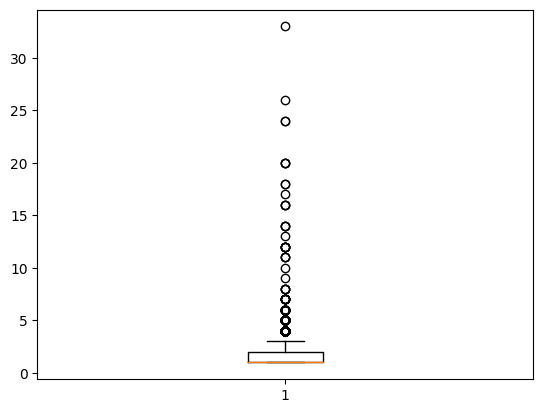

In [65]:
plt.boxplot(df['beds'])

In [66]:
df=reemplazar_outliers(df, "beds")

*Price*

In [67]:
df['price'].describe()

count     4928.000000
mean       220.822646
std       1097.823797
min          0.000000
25%        119.000000
50%        166.000000
75%        246.000000
max      71536.000000
Name: price, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa5dd24c1c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa5dd24c670>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa5dd29bee0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa5dd24cbb0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa5dd24ce50>],
 'means': []}

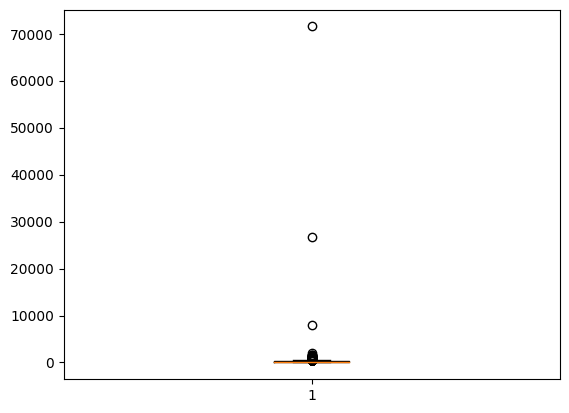

In [68]:
plt.boxplot(df['price'])

In [69]:
df=reemplazar_outliers(df, "price")

In [70]:
df=reemplazar_outliers(df, "minimum_maximum_nights")

In [71]:
df=reemplazar_outliers(df, "maximum_maximum_nights")

# **Separación de Datos**

In [73]:
X = df.drop(columns=['review_scores_rating'])
y = df['review_scores_rating']

In [74]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=33)

In [ ]:
X.columns

In [ ]:
X_val.shape

# **Modelos**

In [ ]:
df.head(5)

## **Regresión Linear**

In [ ]:
reg = LinearRegression()

In [ ]:
modelo_lr=reg.fit(X_train,y_train)

In [ ]:
print("R2 score:",reg.score(X_val,y_val))

R2 score: 0.727358208247531


## **Multiple linear regression**

In [ ]:
mlr = LinearRegression()  
mlr.fit(X_train, y_train)

In [ ]:
y_pred_mlr= mlr.predict(X_val)
mlr.score(X_train, y_train)

0.49740280323902564

## **Ridge Regression**

In [ ]:
ridge = Ridge(alpha=1.0)

In [ ]:
ridge=ridge.fit(X_train, y_train)

In [ ]:
print("R2 score:",ridge.score(X_val,y_val))

R2 score: 0.7277287277152921


## **Decision Tree Regressor**

In [ ]:
regressor = DecisionTreeRegressor(random_state = 0, max_depth=4)  
regressor.fit(X, y) 

In [ ]:
print("R2 score:",regressor.score(X_val, y_val))

R2 score: 0.6978791520942806


## **RandomForest Regression**

In [ ]:
rf = RandomForestRegressor(n_estimators = 500, max_features = 'auto', max_depth =10, random_state = 25)

In [ ]:
rf.fit(X_train, y_train)

In [ ]:
print("R2 score:",rf.score(X_val,y_val))

R2 score: 0.7314398971675821


Grid Search

In [ ]:
rf_p = RandomForestRegressor()

In [ ]:
param_grid = {
    'n_estimators': [100, 200,500], 
    'max_depth': [None, 5, 10], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4]  
}

In [ ]:
grid_search = GridSearchCV(estimator=rf_p, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
model_rf_grid =RandomForestRegressor(max_depth=None,
                                   n_estimators=500, 
                                   min_samples_split=2,
                                   min_samples_leaf=1)
modelo_rfgrid=model_rf_grid.fit(X_train, y_train)
print("R2 score:",modelo_rfgrid.score(X_val,y_val))

R2 score: 0.7319362900379118


Random Search

In [ ]:
RF_Random = RandomForestRegressor(random_state=35)

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)]
min_samples_split = [2, 6, 10]
min_samples_leaf = [1, 3, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
'max_features': max_features,
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf,
'bootstrap': bootstrap}

In [ ]:
rf_random = RandomizedSearchCV(estimator = RF_Random,param_distributions = random_grid,n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)
rf_random.fit(X,y)

In [ ]:
print ('Best Parameters: ', rf_random.best_params_, ' \n')

In [ ]:
model_grid = RandomForestRegressor(max_depth=100,
                                   max_features='auto',
                                   n_estimators=14, 
                                   min_samples_split=6,
                                   min_samples_leaf=1,
                                   bootstrap=True)
modelo_rfgrid=model_grid.fit(X_train, y_train)
print("R2 score:",modelo_rfgrid.score(X_val,y_val))

## **XG Boost**

In [ ]:
XGB=XGBRegressor()

In [ ]:
XGB = XGB.fit(X_train,y_train)
print("R2 score:",XGB.score(X_val, y_val))

R2 score: 0.7044916654677903


Grid

In [ ]:
grid_search_params = {
    'colsample_bytree': [0.3, 0.7],
    'learning_rate': [0.01, 0.1, 0.2, 0.5,0.10,0.12],
    'n_estimators': [100,200],
    'subsample': [0.2, 0.5, 0.8],
    'max_depth': [2, 3, 5,10]
}

In [ ]:
xg_grid_reg =XGBRegressor(objective= "reg:squarederror")

In [ ]:
grid = GridSearchCV(estimator=xg_grid_reg, param_grid=grid_search_params, scoring='neg_mean_squared_error',
                    cv=4, verbose=1)

In [ ]:
grid.fit(X_train, y_train)
print("GridSearchCV")
print("Best parameters found: ", grid.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid.best_score_)))

In [ ]:
model_XGgrid = XGBRegressor(colsample_bytree= 0.3,
                            learning_rate= 0.1,
                            n_estimators= 200,
                            subsample= 0.8,
                            max_depth= 3)
modelo_XGgrid=model_XGgrid.fit(X_train, y_train)
print("R2 score:",modelo_XGgrid.score(X_val,y_val))

R2 score: 0.7268516080446434


## **Gradient Boosting Regressor**

In [ ]:
GBR = GradientBoostingRegressor()

In [ ]:
GBR.fit(X_train,y_train)

In [ ]:
print("R2 score:",GBR.score(X_val,y_val))

R2 score: 0.7203672205602945


Grid

In [ ]:
grid = dict()
grid['n_estimators'] = [10, 50, 100,200,500]
grid['learning_rate'] = [0.001,0.01, 0.1, 1.0]
grid['subsample'] = [0.5, 0.7, 1.0]
grid['max_depth'] = [3, 7, 9]

In [ ]:
grid_search = GridSearchCV(estimator=GBR, param_grid=grid, n_jobs=-1, cv=4)
grid_result = grid_search.fit(X_train, y_train)

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
model_GBgrid = XGBRegressor(
                            learning_rate= 0.01,
                            n_estimators= 500,
                            subsample= 0.7,
                            max_depth= 7)
modelo_GBgrid=model_GBgrid.fit(X_train, y_train)
print("R2 score:",modelo_GBgrid.score(X_val,y_val))

R2 score: 0.7165445262031838


## **LGBM**

In [ ]:
LGBM=lgb.LGBMRegressor()

In [ ]:
LGBM.fit(X_train,y_train)

LGBMRegressor()

In [ ]:
print("R2 score:",LGBM.score(X_val,y_val))

R2 score: 0.662649248720504


## **CatBoost**

In [75]:
train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_val, y_val)

In [76]:
model_CB = cb.CatBoostRegressor(loss_function="RMSE")

In [ ]:
grid = {'iterations': [100, 150, 200,500],
        'learning_rate': [0.03, 0.01,0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model_CB.grid_search(grid, train_dataset)

In [ ]:
best_params = model_CB.get_params()

In [ ]:
print("\n Best parameters:\n",best_params)

In [ ]:
model_CBgrid = cb.CatBoostRegressor(
                            depth= 4,
                            iterations= 150,
                            l2_leaf_reg= 0.5,
                            learning_rate= 0.1)
modelo_CBgrid=model_CBgrid.fit(X_train, y_train)
print("R2 score:",modelo_CBgrid.score(X_val,y_val))

In [ ]:
pred = model_CB.predict(X_val)
rmse = (np.sqrt(mean_squared_error(y_val, pred)))
r2 = r2_score(y_val, pred)
print("Testing performance")
print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

Testing performance
RMSE: 0.11
R2: 0.73


# **Salida**

## **Carga de Datos**

In [78]:
test=pd.read_csv("base_val.csv", sep=",")

In [79]:
test_t=pd.DataFrame()

In [80]:
test_t=test

In [ ]:
test_t.describe().T

## **Variables Numericas**

### Id, Neighbourhood group , Calendar

In [81]:
test_t=test_t.drop(["id","neighbourhood_group_cleansed", "calendar_updated"], axis=1)

### Convierto a 0 o 1 las variables T o F

In [82]:
test_t.loc[test_t["instant_bookable"]=="f", "instant_bookable"] = 0
test_t.loc[test_t["instant_bookable"]=="t", "instant_bookable"] = 1
test_t.loc[test_t["host_has_profile_pic"]=="f", "host_has_profile_pic"] = 0
test_t.loc[test_t["host_has_profile_pic"]=="t", "host_has_profile_pic"] = 1
test_t.loc[test_t["host_identity_verified"]=="f", "host_identity_verified"] = 0
test_t.loc[test_t["host_identity_verified"]=="t", "host_identity_verified"] = 1
test_t.loc[test_t["host_is_superhost"]=="f", "host_is_superhost"] = 0
test_t.loc[test_t["host_is_superhost"]=="t", "host_is_superhost"] = 1
test_t.loc[test_t["has_availability"]=="f", "has_availability"] = 0
test_t.loc[test_t["has_availability"]=="t", "has_availability"] = 1

In [83]:
test_t = test_t.astype({'instant_bookable':'int64', 'host_has_profile_pic':'int64','host_identity_verified':'int64','host_is_superhost':'int64','has_availability':'int64'})

### Variable Price

In [84]:
# Remuevo $ y , de la variable
test_t.price = test_t.price.str.replace('$', '')
test_t.price = test_t.price.str.replace(',', '')
test_t.price = test_t.price.astype(float)

# convierto a int
test_t.price = pd.to_numeric(test_t.price, errors='coerce')

<ipython-input-84-6c09251c5ce9>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  test_t.price = test_t.price.str.replace('$', '')


###Response rate y Acceptance Rate

In [85]:
test_t.host_response_rate = test_t.host_response_rate.str.replace('%', '')
test_t["host_response_rate"]=mean_imputer.fit_transform(test_t['host_response_rate'].values.reshape(-1,1))
test_t.host_acceptance_rate = test_t.host_acceptance_rate.str.replace('%', '')
test_t["host_acceptance_rate"]=mean_imputer.fit_transform(test_t['host_acceptance_rate'].values.reshape(-1,1))
test_t = test_t.astype({'host_response_rate':'int64', 'host_acceptance_rate':'int64'})

### Bathroom

In [86]:
test_t['bathrooms_numeric'] = test_t['bathrooms_text'].str.extract('(\d+\.\d+)', expand=False)
test_t["bathrooms"]=test_t['bathrooms_numeric']
test_t=test_t.drop(["bathrooms_numeric"], axis=1)
test_t.loc[test_t["bathrooms"].isnull()==True, "bathrooms"] =test_t['bathrooms_text'].str.extract('(\d)', expand=False)
test_t.bathrooms =test_t.bathrooms.astype(float)

## Variables Categoricas

In [87]:
test_t=test_t.drop(["name","description", "neighborhood_overview","host_name", "host_about", "host_neighbourhood", "neighbourhood","bathrooms_text", "license" ], axis=1)

*Source*

In [88]:
source_nueva=pd.get_dummies(test_t["source"],prefix="source")
source_nueva=source_nueva.drop(["source_previous scrape"],axis=1)
test_t=test_t.drop(["source"],axis=1)
test_t["Source"]=source_nueva

*Response Time*

In [89]:
host_response_time(test_t)

,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,...,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,Source
0,3842476,2012-10-11,"Lisbon, Portugal",4,95,100,0,1,2,"['email', 'phone']",...,5.00,5.00,5.00,1,1,1,0,0,0.39,0
1,45419738,2015-09-30,"Amsterdam, Netherlands",1,100,89,0,1,1,"['email', 'phone']",...,5.00,4.83,4.67,0,1,1,0,0,0.71,0
2,205620290,2018-07-28,"Amsterdam, Netherlands",4,60,47,0,1,2,"['email', 'phone']",...,5.00,3.50,3.75,0,1,1,0,0,0.59,1
3,73798820,2016-05-24,"Amsterdam, Netherlands",4,95,100,0,1,2,"['email', 'phone']",...,5.00,5.00,5.00,1,1,1,0,0,0.37,0
4,425744204,2021-10-03,NaN,2,100,42,0,1,1,['phone'],...,5.00,4.83,5.00,0,1,1,0,0,1.06,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228,4184910,2012-11-18,"Amsterdam, Netherlands",4,80,88,1,1,1,"['email', 'phone']",...,4.71,4.93,4.59,0,1,0,1,0,2.88,1
1229,4215174,2012-11-22,"Amsterdam, Netherlands",4,100,0,0,1,1,"['email', 'phone']",...,5.00,4.67,4.50,0,1,1,0,0,0.15,1
1230,1657181,2012-01-26,"Amsterdam, Netherlands",1,100,83,0,1,2,"['email', 'phone', 'work_email']",...,4.71,4.76,4.41,0,1,1,0,0,0.83,0
1231,4221960,2012-11-23,"Amsterdam, Netherlands",1,100,99,1,1,1,"['email', 'phone']",...,4.97,4.92,4.81,0,1,0,1,0,8.69,1


*host_location*, *neighbourhood_cleansed*, *property_type*

In [90]:
test_t.loc[test_t["host_location"]=="CA", "host_location"] = "USA"
test_t.loc[test_t["host_location"]=="CO", "host_location"] = "USA"
test_t.loc[test_t["host_location"]=="DC", "host_location"] = "USA"
test_t.loc[test_t["host_location"]=="FL", "host_location"] = "USA"
test_t.loc[test_t["host_location"]=="IL", "host_location"] = "USA"
test_t.loc[test_t["host_location"]=="NY", "host_location"] = "USA"
test_t.loc[test_t["host_location"]=="RI", "host_location"] = "USA"

In [91]:
test_t.loc[test_t["host_location"].isnull()==True, "host_location"] = "missing"

In [92]:
dl=[]
for i in test_t['host_location']:
  x = i.split(",")
  respuesta_l=func(x,top_5_location)
  dl.append(respuesta_l)
test_t=test_t.drop(["host_location"],axis=1)
test_t['host_location'] = dl

*neighbourhood_cleansed*

In [93]:
dn=[]
for i in test_t['neighbourhood_cleansed']:
  x = i.split("-")
  respuesta_n=func(x,top_5_neighbourhood)
  dn.append(respuesta_n)
test_t=test_t.drop(["neighbourhood_cleansed"],axis=1)
test_t['neighbourhood_cleansed'] = dn

*property_type*

In [94]:
dp=[]
for i in test_t['property_type']:
  x = i.split("-")
  respuesta_p=func(x,top_5_property)
  dp.append(respuesta_p)
test_t=test_t.drop(["property_type"],axis=1)
test_t['property_type'] = dp

*Amenities*

In [95]:
test_t.amenities = test_t.amenities.str.replace('[', '')
test_t.amenities = test_t.amenities.str.replace(']', '')
test_t.amenities = test_t.amenities.str.replace('"', '')
test_t.amenities = test_t.amenities.str.replace('.', '')
test_t.amenities = test_t["amenities"].str.lstrip()
test_t['Amenities']=test_t["amenities"].apply(lambda x: len(x.split(',')))

<ipython-input-95-aa1767a79b15>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  test_t.amenities = test_t.amenities.str.replace('[', '')
<ipython-input-95-aa1767a79b15>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  test_t.amenities = test_t.amenities.str.replace(']', '')
<ipython-input-95-aa1767a79b15>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  test_t.amenities = test_t.amenities.str.replace('.', '')


In [96]:
test_t=test_t.drop(["amenities"],axis=1)

In [97]:
test_t = test_t.astype({'host_location':'int64', 'neighbourhood_cleansed':'int64','property_type':'int64'})

*Room_type*

In [98]:
test_t.loc[test_t["room_type"]=="Private room", "room_type"] = 1
test_t.loc[test_t["room_type"]=="Entire home/apt", "room_type"] = 1
test_t.loc[test_t["room_type"]=="Hotel room", "room_type"] = 1
test_t.loc[test_t["room_type"]=="Shared room", "room_type"] = 0
test_t = test_t.astype({'room_type':'int64'})

*host_Verification*

In [99]:
test_t.host_verifications = test_t.host_verifications.str.replace('[', '')
test_t.host_verifications = test_t.host_verifications.str.replace(']', '')

<ipython-input-99-b2bd330e47ed>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  test_t.host_verifications = test_t.host_verifications.str.replace('[', '')
<ipython-input-99-b2bd330e47ed>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  test_t.host_verifications = test_t.host_verifications.str.replace(']', '')


In [100]:
email=[]
find_word="email"
for i in test_t["host_verifications"]:
  if find_word in i:
    email.append(1)
  else:
    email.append(0)

In [101]:
phone=[]
find_word="phone"
for i in test_t["host_verifications"]:
  if find_word in i:
    phone.append(1)
  else:
    phone.append(0)

In [102]:
work=[]
find_word="work_email"
for i in test_t["host_verifications"]:
  if find_word in i:
    work.append(1)
  else:
    work.append(0)

In [103]:
test_t["email"]=email
test_t["phone"]=phone
test_t["work_email"]=work
test_t=test_t.drop(["host_verifications"],axis=1)

*host_since, calendar_last_scraped, first_review, last_review*

In [104]:
test_t['host_since'] = pd.to_datetime(test_t['host_since'])
test_t['calendar_last_scraped'] = pd.to_datetime(test_t['calendar_last_scraped'])
test_t['first_review'] = pd.to_datetime(test_t['first_review'])
test_t['last_review'] = pd.to_datetime(test_t['last_review'])

In [105]:
test_t['host_since'] = test_t['host_since'].dt.strftime('%Y%m%d').astype('int64')
test_t['calendar_last_scraped'] = test_t['calendar_last_scraped'].dt.strftime('%Y%m%d').astype('int64')
test_t['first_review'] = test_t['first_review'].dt.strftime('%Y%m%d').astype('int64')
test_t['last_review'] = test_t['last_review'].dt.strftime('%Y%m%d').astype('int64')

## Missing

In [ ]:
test_t.describe().T

In [107]:
test_t["bathrooms"]=mean_imputer.fit_transform(test_t['bathrooms'].values.reshape(-1,1))

In [108]:
test_t["bedrooms"]=mean_imputer.fit_transform(test_t['bedrooms'].values.reshape(-1,1))

In [109]:
test_t["beds"]=mean_imputer.fit_transform(test_t['beds'].values.reshape(-1,1))

# **Final Document**

In [ ]:
test_t.head(10)

In [ ]:
resultado=modelo_CBgrid.predict(test_t)

In [ ]:
salida = pd.DataFrame(data={"review_scores_rating": resultado}).astype(str)
salida.index = test.id
salida.to_csv("modelo_GBgrid_.csv", sep=',',index=True,  index_label='Id')